In [1]:
import xarray as xr
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from metpy.units import units
from metpy import calc as mpcalc
from windrose import WindroseAxes

In [2]:
file = 'sggj_data.csv' 
dataset = pd.read_csv(file)
dataset_time_array = np.array(dataset['datetime'])
dataset_time_array_numpy = dataset_time_array.astype('datetime64[s]')
time_correction = datetime(1970, 1, 1, 0, 0, 0) - datetime(1904, 1, 1, 0, 0, 0)
time_correction_numpy = np.array([time_correction]).astype('timedelta64[s]')[0]
datetime_proper = dataset_time_array_numpy - time_correction_numpy
dataset['corrected_dts'] = datetime_proper
dataset.rename(columns={'youngWD': 'youngWD_relative'}, inplace=True)
dataset['gillU'], dataset['gillV'] = mpcalc.wind_components(dataset['gillWS'].values * (units.meters/units.seconds),
                                                            dataset['gillWD'].values * units.deg)
dataset['ftU'], dataset['ftV'] = mpcalc.wind_components(dataset['ftWS'].values * (units.meters/units.seconds),
                                                          dataset['ftWD'].values * units.deg)
dataset.set_index('corrected_dts', inplace=True, drop=True)
dataset.drop(columns=['datetime'], inplace=True)
dataset

,youngWS,youngWD_relative,gillWS,gillWD,ftWS,ftWD,gillU,gillV,ftU,ftV
corrected_dts,,,,,,,,,,
2024-04-18 14:28:10,1.802,233.366,1.56,50.0,1.9,65.0,-1.195029,-1.002749,-1.721985,-0.802975
2024-04-18 14:28:11,2.176,215.749,2.96,78.0,2.4,63.0,-2.895317,-0.615419,-2.138416,-1.089577
2024-04-18 14:28:12,2.899,232.680,3.92,65.0,3.2,62.0,-3.552727,-1.656664,-2.825432,-1.502309
2024-04-18 14:28:13,2.833,200.615,3.23,51.0,3.2,49.0,-2.510181,-2.032705,-2.415071,-2.099389
2024-04-18 14:28:14,2.206,169.306,1.92,64.0,2.9,41.0,-1.725685,-0.841673,-1.902571,-2.188658
...,...,...,...,...,...,...,...,...,...,...
2024-04-19 14:34:23,5.221,200.142,4.56,58.0,4.3,65.0,-3.867099,-2.416432,-3.897123,-1.817259
2024-04-19 14:34:24,5.142,192.669,4.87,61.0,4.2,57.0,-4.259398,-2.361023,-3.522416,-2.287484
2024-04-19 14:34:25,4.912,227.797,3.98,54.0,4.3,56.0,-3.219888,-2.339385,-3.564862,-2.404529


Text(0, 0.5, 'wind speed (m/s)')

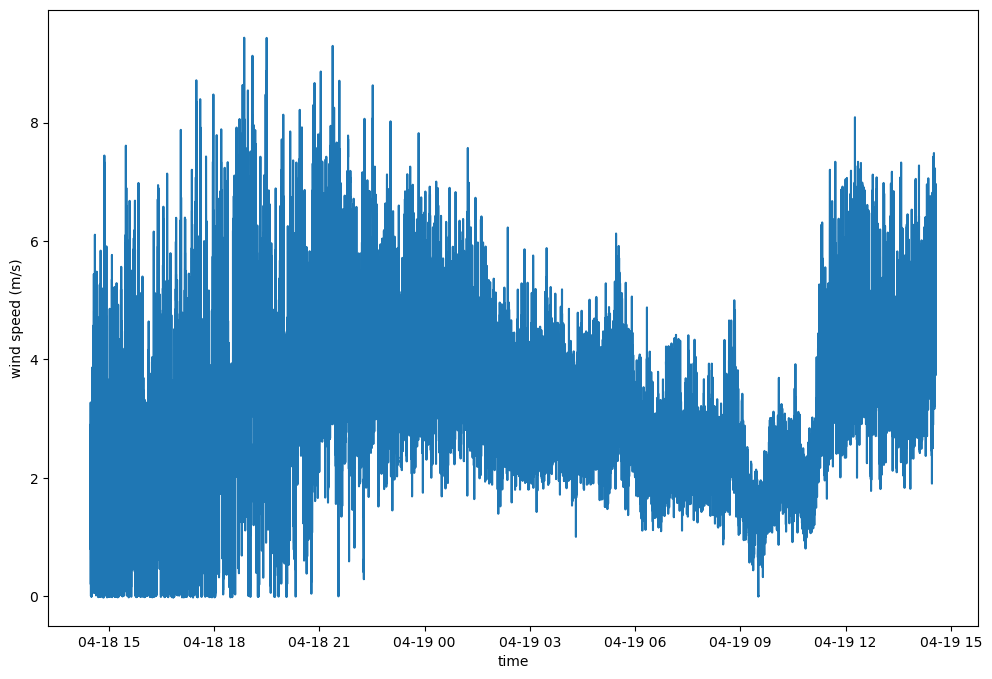

In [3]:
plt.figure(figsize = (12, 8))
plt.plot(dataset.index, dataset['youngWS'])
plt.xlabel('time')
plt.ylabel('wind speed (m/s)')

In [4]:
mean_young = np.mean(dataset['youngWS'])

In [5]:
young_dif_ws = np.power(np.subtract(dataset['youngWS'], mean_young),2)
young_ws_variance = young_dif_ws/np.size(dataset['youngWS'])
young_ws_std_dev = np.sqrt(young_ws_variance)

Text(0, 0.5, 'wind speed variance(m/s)')

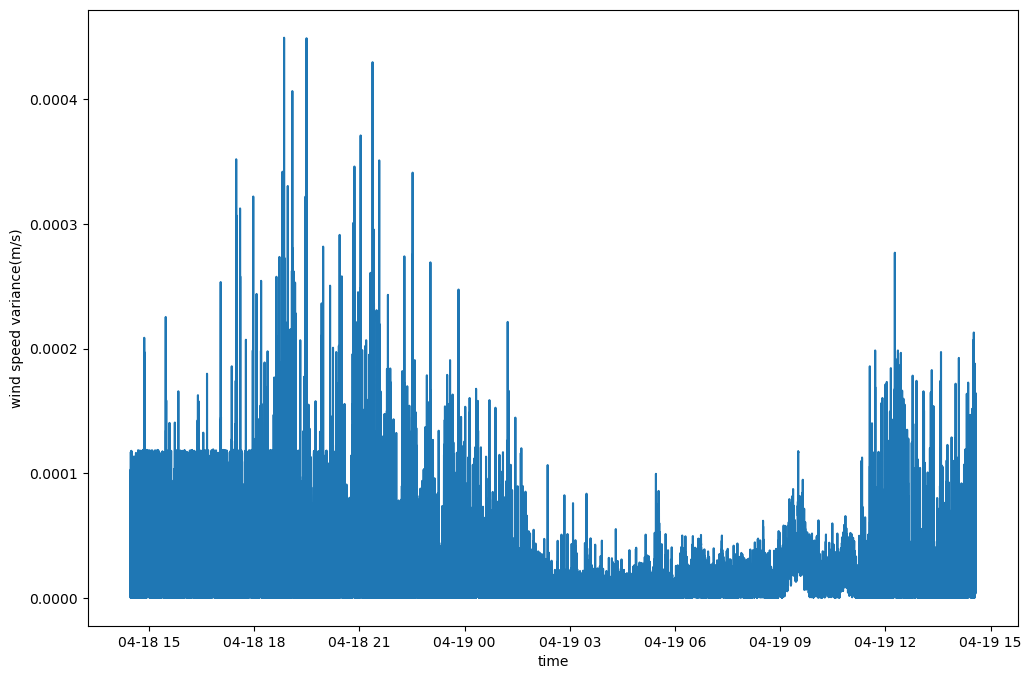

In [6]:
plt.figure(figsize = (12, 8))
plt.plot(dataset.index, young_ws_variance)
plt.xlabel('time')
plt.ylabel('wind speed variance(m/s)')

Text(0, 0.5, 'wind speed standard deviation (m/s)')

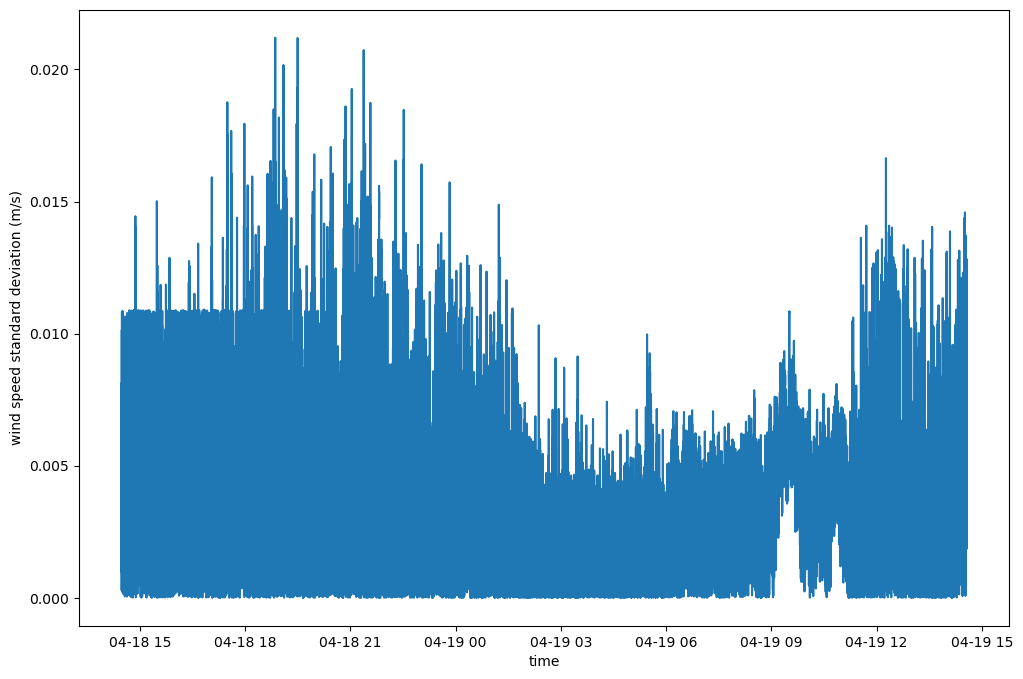

In [7]:
plt.figure(figsize = (12, 8))
plt.plot(dataset.index, young_ws_std_dev)
plt.xlabel('time')
plt.ylabel('wind speed standard deviation (m/s)')

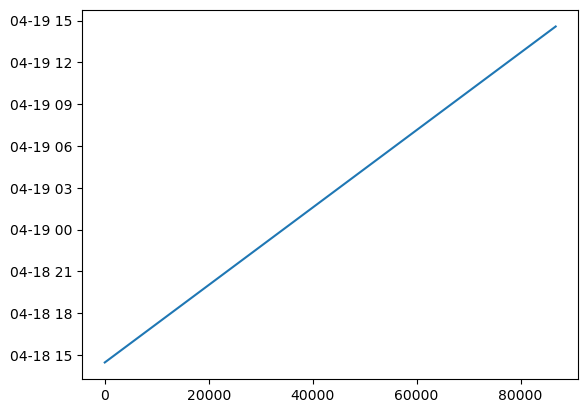

In [8]:
timeDriftFig = plt.figure()
timeDriftAx = timeDriftFig.gca()
timeDriftAx.plot(np.arange(0, np.size(dataset.index)), dataset.index)

In [9]:
expected_time_differences = np.arange(0, np.size(dataset.index)) * np.timedelta64(1000, 'ms')

In [10]:
expected_times = dataset.index[0] + expected_time_differences

In [11]:
timeDriftAx.plot(np.arange(0, np.size(dataset.index)), expected_times, color='gray', alpha=0.5)

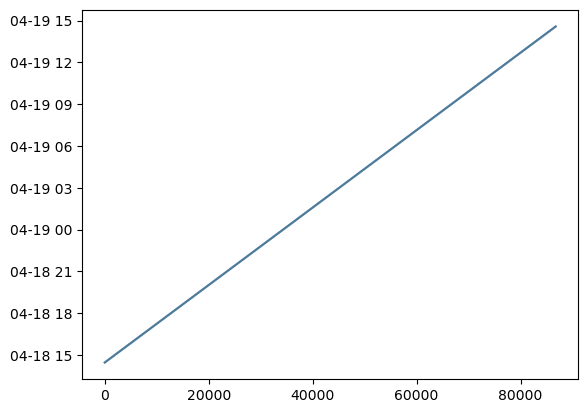

In [12]:
timeDriftFig

In [13]:
actualSampleRate = (dataset.index[-1] - dataset.index[0]) / np.size(dataset.index)

In [14]:
dataset.index[-1]

Timestamp('2024-04-19 14:34:27')

In [15]:
fast_winds = dataset[(dataset['gillWS'] > 3) & (dataset['ftWS'] > 3)]

In [16]:
fast_winds['sonicU'] = (fast_winds['gillU'] + fast_winds['ftU'])/2
fast_winds['sonicV'] = (fast_winds['gillV'] + fast_winds['ftV'])/2
fast_winds['sonicWS'] = mpcalc.wind_speed(fast_winds['sonicU'].values * (units.meter/units.seconds),
                                          fast_winds['sonicV'].values * (units.meter/units.seconds))
fast_winds['sonicWD'] = mpcalc.wind_direction(fast_winds['sonicU'].values * (units.meter/units.seconds),
                                              fast_winds['sonicV'].values * (units.meter/units.seconds))

/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_61320/3501061679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fast_winds['sonicU'] = (fast_winds['gillU'] + fast_winds['ftU'])/2
/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_61320/3501061679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fast_winds['sonicV'] = (fast_winds['gillV'] + fast_winds['ftV'])/2
/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_61320/3501061679.py:3: SettingWithCopyWarning: 
A value is tryi

In [17]:
offset_data = fast_winds[fast_winds['youngWD_relative'] > fast_winds['sonicWD']]

164.792362992103


/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_61320/874215662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offset_data['difference_between_young_and_sonic'] = offset_data['youngWD_relative'] - offset_data['sonicWD']


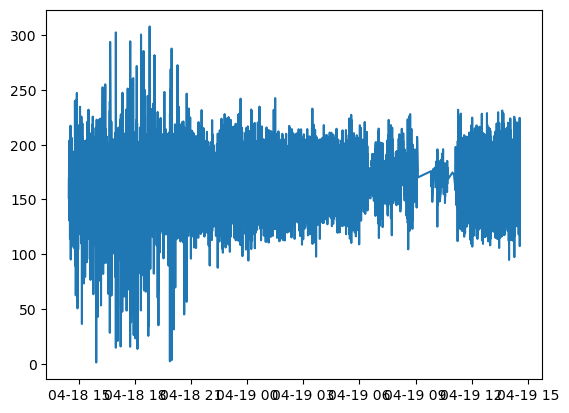

In [18]:
offset_data['difference_between_young_and_sonic'] = offset_data['youngWD_relative'] - offset_data['sonicWD']
offset_plot = plt.figure()
offset_ax = offset_plot.gca()
offset_ax.plot(offset_data.index, offset_data['difference_between_young_and_sonic'])
offset = np.mean(offset_data['difference_between_young_and_sonic'].values)
print(offset)

In [19]:
dataset['youngWD'] = dataset['youngWD_relative'] - offset
dataset['youngU'], dataset['youngV'] = mpcalc.wind_components(dataset['youngWS'].values * (units.meters/units.seconds),
                                                              dataset['youngWD'].values * units.deg)
dataset

,youngWS,youngWD_relative,gillWS,gillWD,ftWS,ftWD,gillU,gillV,ftU,ftV,youngWD,youngU,youngV
corrected_dts,,,,,,,,,,,,,
2024-04-18 14:28:10,1.802,233.366,1.56,50.0,1.9,65.0,-1.195029,-1.002749,-1.721985,-0.802975,68.573637,-1.677460,-0.658280
2024-04-18 14:28:11,2.176,215.749,2.96,78.0,2.4,63.0,-2.895317,-0.615419,-2.138416,-1.089577,50.956637,-1.690033,-1.370681
2024-04-18 14:28:12,2.899,232.680,3.92,65.0,3.2,62.0,-3.552727,-1.656664,-2.825432,-1.502309,67.887637,-2.685771,-1.091254
2024-04-18 14:28:13,2.833,200.615,3.23,51.0,3.2,49.0,-2.510181,-2.032705,-2.415071,-2.099389,35.822637,-1.658093,-2.297089
2024-04-18 14:28:14,2.206,169.306,1.92,64.0,2.9,41.0,-1.725685,-0.841673,-1.902571,-2.188658,4.513637,-0.173604,-2.199158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-19 14:34:23,5.221,200.142,4.56,58.0,4.3,65.0,-3.867099,-2.416432,-3.897123,-1.817259,35.349637,-3.020685,-4.258439
2024-04-19 14:34:24,5.142,192.669,4.87,61.0,4.2,57.0,-4.259398,-2.361023,-3.522416,-2.287484,27.876637,-2.404242,-4.545304
2024-04-19 14:34:25,4.912,227.797,3.98,54.0,4.3,56.0,-3.219888,-2.339385,-3.564862,-2.404529,63.004637,-4.376805,-2.229647


Text(0.5, 0, 'time')

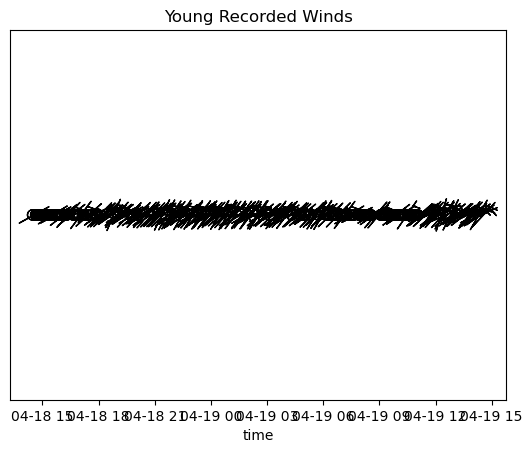

In [20]:
youngFig = plt.figure()
youngAx = youngFig.gca()
youngAx.barbs(dataset.index[::300], 0, dataset['youngU'][::300], dataset['youngV'][::300], pivot="middle", label="Young")
plt.tick_params(left=False, labelleft=False) # gets rid of y axis labels since they have no meaning
plt.title('Young Recorded Winds')
plt.xlabel('time')

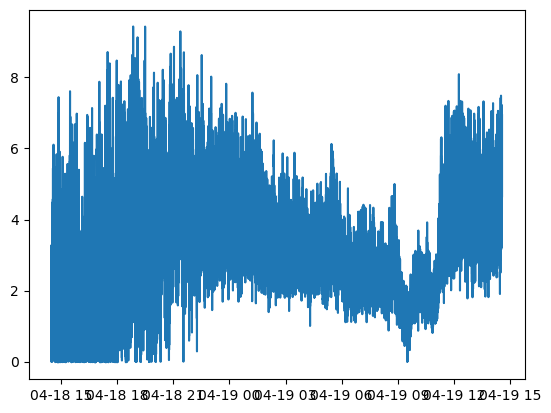

In [21]:
youngWSFig = plt.figure()
youngWSAx = youngWSFig.gca()
youngWSAx.plot(dataset.index, dataset['youngWS'])

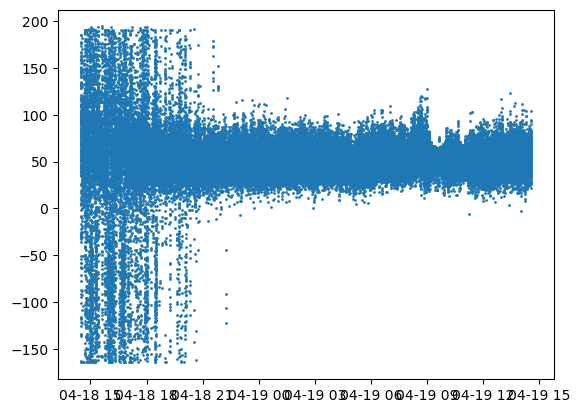

In [22]:
youngWDFigSct = plt.figure()
youngWDAxSct = youngWDFigSct.gca()
youngWDAxSct.scatter(dataset.index, dataset['youngWD'], s=1)

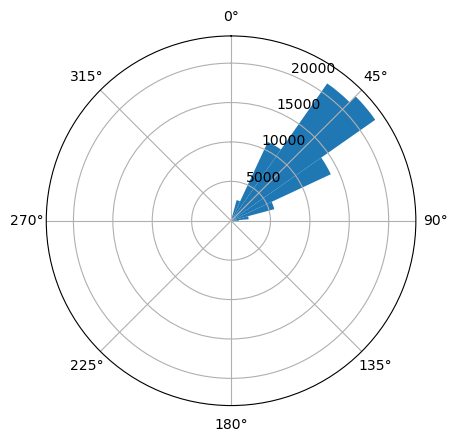

In [23]:
youngWDFig = plt.figure()
youngWDAx = plt.axes(polar=True)
youngWDAx.set_theta_zero_location('N')
youngWDAx.set_theta_direction(-1)

hist, edges = np.histogram(dataset['youngWD'], bins=36, range=[0, 360])
edges = edges[:-1]
edges = np.deg2rad(edges)
width = np.deg2rad(10)

bars = youngWDAx.bar(edges, hist, width=width)

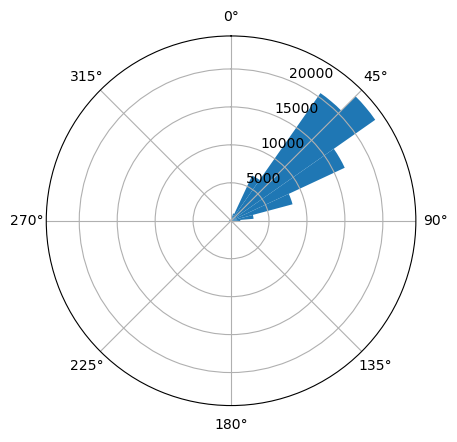

In [24]:
gillWDFig = plt.figure()
gillWDAx = plt.axes(polar=True)
gillWDAx.set_theta_zero_location('N')
gillWDAx.set_theta_direction(-1)

hist, edges = np.histogram(dataset['gillWD'], bins=36, range=[0, 360])
edges = edges[:-1]
edges = np.deg2rad(edges)
width = np.deg2rad(10)

bars = gillWDAx.bar(edges, hist, width=width)

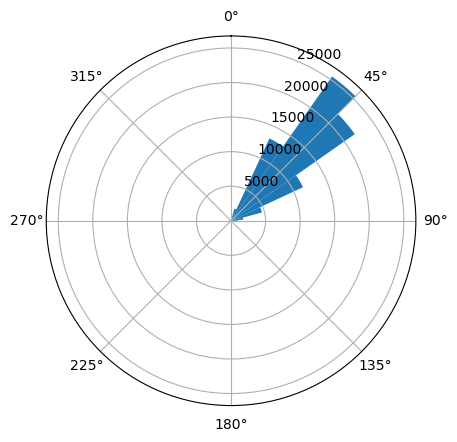

In [25]:
ftWDFig = plt.figure()
ftWDAx = plt.axes(polar=True)
ftWDAx.set_theta_zero_location('N')
ftWDAx.set_theta_direction(-1)

hist, edges = np.histogram(dataset['ftWD'], bins=36, range=[0, 360])
edges = edges[:-1]
edges = np.deg2rad(edges)
width = np.deg2rad(10)

bars = ftWDAx.bar(edges, hist, width=width)

In [26]:
def make_rose(wind_speed, wind_direction, title=None):
    fig = plt.figure()
    ax = WindroseAxes.from_ax(fig=fig)
    ax.bar(wind_direction, wind_speed, normed=False)
    ax.set_legend()
    if title:
        ax.set_title(title)
    return fig

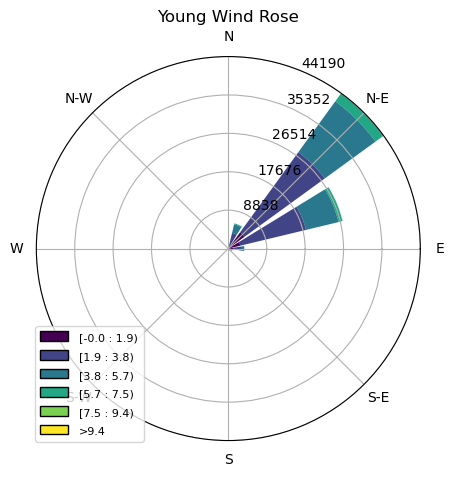

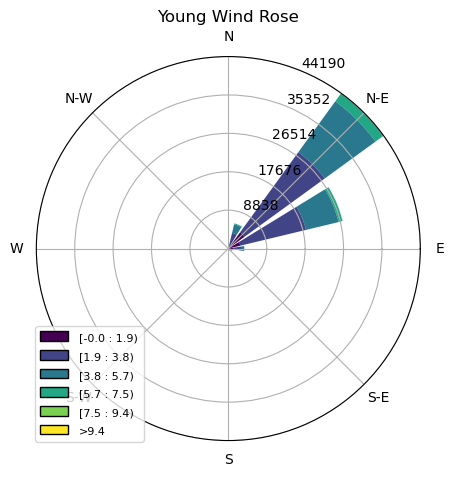

In [27]:
make_rose(dataset['youngWS'], dataset['youngWD'], title='Young Wind Rose')

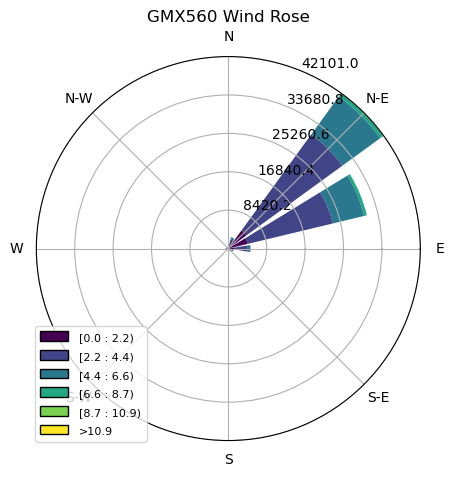

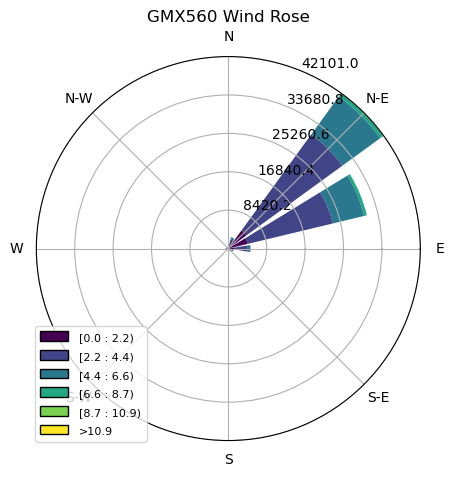

In [28]:
make_rose(dataset['gillWS'], dataset['gillWD'], title='GMX560 Wind Rose')

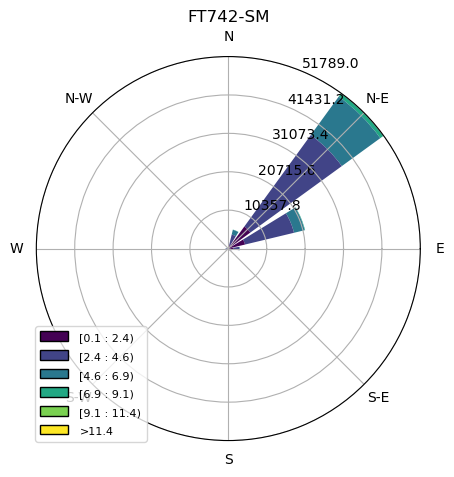

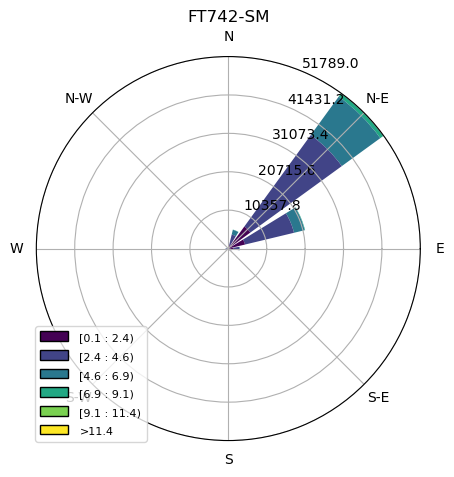

In [29]:
make_rose(dataset['ftWS'], dataset['ftWD'], title='FT742-SM')

In [30]:
# calculate mean 

mean_gill = np.mean(dataset['gillWS'])
gill_ws = dataset['gillWS']

NameError: name 'gill_dataset' is not defined

In [ ]:
# GMX560 variance
gill_ws = dataset['gillWS']
gill_ws_prime = gill_ws - np.nanmean(gill_ws)
gill_ws_squared = gill_ws_prime * gill_ws_prime

# to get the variance, we need the mean of gill_ws_squared
gill_ws_series = pd.Series(gill_ws_squared)

# 3 point moving varience
window_size3 = 3
windows3 = gill_ws_series.rolling(window_size3)
moving_averages3 = windows3.mean()
moving_var_list3 = moving_averages3.tolist()
moving_var3 = moving_var_list3[window_size3-1:]
#results under moving variance 3

In [ ]:
# 10 pt moving varience
window_size10 = 10
windows10 = gill_ws_series.rolling(window_size10)
moving_averages10 = windows10.mean()
moving_var_list10 = moving_averages10.tolist()
moving_var10 = moving_var_list10[window_size10-1:]

In [ ]:
plt.figure(figsize = (12, 8))
plt.plot(dataset.index, gill_ws_squared, label='Raw')
plt.plot(dataset.index, moving_var_list3, label='3-pt')
plt.plot(dataset.index, moving_var_list10, label='10-pt')
plt.xlabel('time')
plt.ylabel('wind speed variance(m/s)')
plt.legend()
plt.title('WNS variance time history GMX560')


In [ ]:
#  Gill time history raw data
plt.figure(figsize = (12, 8))
plt.plot(dataset.index, dataset['gillWS'])
plt.xlabel('time')
plt.ylabel('wind speed (m/s)')
plt.title('WNS Time History GMX560')


In [ ]:
# WND u component
plt.figure(figsize = (12, 8))
plt.plot(dataset.index, dataset['gillU'])
plt.xlabel('time')
plt.ylabel('u wind (m/s)')
plt.title('u wind time history GMX560')

In [ ]:
# WND v component
plt.figure(figsize = (12, 8))
plt.plot(dataset.index, dataset['gillV'])
plt.xlabel('time')
plt.ylabel('v wind (m/s)')
plt.title('v wind time history GMX560')

In [ ]:
# all 3 sensors raw wind data 
plt.figure(figsize=(12,8))
plt.plot(dataset.index[::500], dataset['youngWS'][::500], label='RM-Young', linestyle='--')
plt.plot(dataset.index[::500], dataset['ftWS'][::500], label='FT742-SM', linestyle=':')
plt.plot(dataset.index[::500], dataset['gillWS'][::500], label='GMX560', linestyle='-.')
plt.xlabel('time [UTC]')
plt.ylabel('wind speed [m/s]')
plt.legend()
plt.title('Raw Wind Speed for all three sensors')
